In [688]:
%load_ext oct2py.ipython
import networkx as nx
import numpy as np
from scipy.spatial.distance import pdist, squareform
import math
#import matplotlib.pyplot as plt

The oct2py.ipython extension is already loaded. To reload it, use:
  %reload_ext oct2py.ipython


In [689]:
from oct2py import octave
_ = octave.addpath('/home/urban_communities/scripts') # KERDES HOL VAN?
_ = octave.addpath('/home/ubuntu/GenLouvain/')
_ = octave.addpath('/home/ubuntu/GenLouvain/private/')
from time import time
from copy import deepcopy

In [690]:
%matplotlib inline

* Ctrl + shift + - tori el a cellat
* Shift + M = merge
* az ocatve-ban a ' a transzponalas
* az octave szigoruan megkulonbozteti a sor- es oszlopvektorokat
* az octave vektor/matrix objektumai jobban hasonlitanak a np.matrix-ra mint az array-re
* az octave-ban a ./ .* stb. mindig az elemenkenti muveleteket jelentik, mintha np.array-ekkel dolgoznal
* az octave 1-tol indexel, a Python 0-tol

/home/ubuntu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


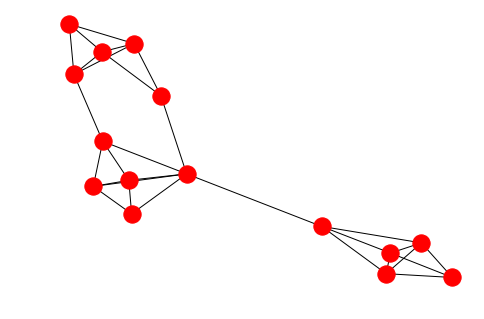

In [691]:
# Eszter graph
# a good modular input matrix
p = np.ones((3,3))*0.05 + np.eye(3)*(1-3*0.05)
G = nx.stochastic_block_model([5]*3,p) # 20 helyett 5
nx.draw(G)

In [692]:
# adjacency matrix
A = nx.adjacency_matrix(G)
# distance matrix
D = np.random.rand(len(G.nodes()),len(G.nodes()))
# importance
N = np.matrix([v for (k,v) in G.degree]).T # KERDES nem lenne jobb meghagyni vektornak, ha ugyis 1 dimenzios??
# binsize
b = 0.05

In [693]:
A.todense()

matrix([[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0]], dtype=int64)

In [694]:
# TRY- modified code without loops to test code line by line

In [695]:
%%octave -i A,D,N,b -o Ms,Mg,Dfn,S,Q,n_it,N,nGN,nSpa,deg,nev

addpath('/home/ubuntu/GenLouvain/')
addpath('/home/ubuntu/GenLouvain/private/')
function [ModularitySpa,ModularityGN,DeterrenceFct,nullmodelGN,nullmodelSpa,degree,nevezo]=ModularitySpaGN(Flow,Dist,N,binsize);
    % Flow: Adjacency matrix
    % Dist: Distance matrix between the nodes
    % N: a measure of the importance of a node (by default its strength: Dist=sum(Flow,1); for example)
    % binsize: size of the bins in the estimation of the deterrence function
    % (has to be tuned according to the problem)
    
    %disp("Beginning of modularity function...");

    number=size(Flow,1); %number of nodes in the system

    nbox=100; %number of bins, might need to increase it depending on your system and of level of coarse-graining

    % intialisation of different vectors and matrices
    DeterrenceFct=zeros(nbox,1);
    normaDeterrence=zeros(nbox,1);

    matrixdistance=zeros(number,number);
    nullmodelGN=zeros(number,number);
    nullmodelSpa=zeros(number,number);

    Flow=Flow+Flow'; %symmetrised matrix (doesn't change the outcome of community detection (arXiv:0812.1770))
    degree=sum(Flow); % degree/strength of the nodes
    nullN=N*N'; % matrix of the importance of nodes
    matrix=Flow./nullN; % normalised adjacency matrix
    
    %disp("Preparation done.")
    
    %disp("Deterrence function...")

    %We first calculate the correlations as a function of distance

    for i=1:number
        %disp(i)
        for ii=1:number

        % convert distances in binsize's units
        dist=ceil(Dist(i,ii)/binsize); %%%%%%% KERDES: NEM ERTEK VELE EGYET, KITOROLheTEM A +1-ET??
        matrixdistance(i,ii)=dist;

        % weighted average for the deterrence function
        num=matrix(i,ii);
        DeterrenceFct(dist,1)=DeterrenceFct(dist,1)+num*N(i,1)*N(ii,1);
        normaDeterrence(dist,1)=normaDeterrence(dist,1)+N(i,1)*N(ii,1);
        end 
    end
    %disp("Done.")

    %disp("Normalization...")
    % normalisation of the deterrence function
    for i=1:nbox
        %disp(i)
        if(normaDeterrence(i,1)~=0)
            DeterrenceFct(i,1)=DeterrenceFct(i,1)/normaDeterrence(i,1);
        end
    end
    
    %disp("Done.")
    
    %disp("Null modell...")

    % copmutation of the randomised correlations (preserving space), spatial
    % null-model
    for i=1:number
        for ii=1:number
            nullmodelSpa(i,ii)=DeterrenceFct(matrixdistance(i,ii),1);
        end 
    end
    
    %disp("Done.")

    %disp("Modularity calc...")
    % the modularity matrix for the spatial null-model
    ModularitySpa=Flow-nullN.*nullmodelSpa*sum(sum(Flow))/sum(sum(nullN.*nullmodelSpa));
    
    nevezo = nullN.*nullmodelSpa*sum(sum(Flow))

    % the modularity matrix for the GN null-model
    nullmodelGN=degree'*degree/(sum(degree)); % Newman-Girvan null-model
    ModularityGN=Flow-nullmodelGN;
    %disp("Done.")
endfunction


[Ms,Mg,Dfn,nGN,nSpa,deg,nev] = ModularitySpaGN(A,D,N,b);
[S,Q,n_it] = iterated_genlouvain(Ms);

nevezo =

 Columns 1 through 8:

    56.456    47.794    55.403   103.111    65.123    38.667    41.944    29.935

    47.794    31.757    47.794    58.817    46.659    77.333    94.909    45.639

   126.545    45.639    38.667    84.684   126.545    52.282    52.282    56.456

   154.667    62.328   119.742   118.189    78.423    78.792    99.429    78.423

   126.545    77.333   103.111    97.684    38.667    52.528   103.111    38.667

    41.944    47.794    55.403    58.000    79.828    38.667    52.282    60.852

    62.212    48.842   126.545   148.480    89.806    52.528    38.667    56.456

    65.123    22.452    63.725    58.000    38.667    79.828    56.456    56.456

    67.355    34.994    49.714    62.328    41.552    59.871    46.659    67.355

    60.852    47.794    63.725    97.684    38.667    79.828   126.545   126.545

    62.212    59.871    55.403    83.104    55.403    79.828    38.667    60.852

    74.240    36.632    39.211    68.459    22.452    29.000    42.342    46.659

    65.123    48.842    68.741    93.318    55.403    52.528    29.935    56.456

    29.000    44.903    47.794   111.360    94.909    94.909    77.333    47.794

    38.667    47.794    60.852    62.915    52.528    41.944    63.725    38.667

 Columns 9 through 15:

    51.556    29.935    62.212    31.458    79.828    22.452    65.123

    35.845    31.458    41.552    31.757    22.452    23.593    31.458

    77.333    41.944   103.111    51.556    29.935    29.000    38.667

    63.513    78.792    95.588    63.513    99.429    73.263    83.104

    41.552    41.944    63.725    49.714    65.123    29.000    56.456

    42.342    79.828    89.806    29.000   126.545    41.552    38.667

    29.000    38.667   103.111    39.211    65.123    47.794    52.282

    39.396    41.944    62.212    59.871    55.403    48.842    56.456

    55.680    49.714    46.659    36.632    29.000    44.903    39.396

    48.842    38.667   103.111    51.556    52.528    41.552    89.806

    49.714   103.111   126.545    22.452    66.286    42.342    68.741

    29.408    39.396    29.000    29.408    74.240    34.994    31.458

    67.355    68.741    62.212    67.355    89.806    77.333    60.852

    29.408    59.871    39.396    31.757    47.794    34.994    67.355

    41.552    52.282    63.725    42.342    55.403    94.909    52.282

Ide jon alulra a Python code

In [696]:
def SpaMod(A,D,N,b): # flow - adjacency matrix
    """
    Function that calculates the matrix for the clustering 
    based on spatial null model a la Expert.
    
    Parameters:
    -----------
    
    A : scipy.sparse.csr.csr_matrix
        adjacency matrix
    D : numpy.ndarray
        Distance matrix between the nodes
    N : numpy.matrix
        a measure of the importance of a node
        the number of users living(home-location) in the given tract
    b : float
        size of the bins in the estimation of the deterrence function
    Returns:
    --------
    
    KERDES - ellenorizni
    ModularitySpa : 
    ModularityGN :
    """
    
    tic = time()
    
    print("Beginning of modularity function...");
    
    number=A.shape[0] # number of nodes
    nbox = 20 ## MODIFIED number of bins JAVITASHOZ PROBA!!!!!!
    
    # intialisation of different vectors and matrices
    DeterrenceFct=np.zeros((nbox,1));
    normaDeterrence=np.zeros((nbox,1));
    matrixdistance=np.zeros((number,number));
    nullmodelGN=np.zeros((number,number));
    nullmodelSpa=np.zeros((number,number));
    
    A = A + A.T # felesleges?? KERDES -- symmetrised matrix (doesn't change the outcome of community detection (arXiv:0812.1770))
    
    degree = A.sum(axis=0) 
    # np.squeeze(np.asarray(A.sum(axis=0))) # degree or strength of nodes || asarry for further usage
    # JAVITAS degree matrix formaban hagyva
    
    
    nullN = N * N.T # matrix of the importance of nodes
    
    # matrix = np.divide(A.T,nullN) ## KERDESES, HOGY JO-e
    matrix = A/nullN # normalized adjacency matrix
    
    toc = time()
    print("Done.","%.2f" % (toc-tic))
    tic = toc
    print('Preparation done.')
    
    print('Deterrence function...')

    for i in range(number):
        for ii in range(number):
            
            # convert distances in binsize's units
            dist = math.floor(D[i,ii]/b);
            matrixdistance[i,ii]=dist;

            # weighted average for the deterrence function
            num = matrix[i,ii];
            DeterrenceFct[dist,0]=DeterrenceFct[dist,0]+num*N[i,0]*N[ii,0];
            normaDeterrence[dist,0]=normaDeterrence[dist,0]+N[i,0]*N[ii,0];
            # ALTERNATIVELY
            # ceiler = lambda x: math.ceil(x)
            # vceil = np.vectorize(ceiler)
            # matrixdistance = vceil(D/b)
            # DeterrenceFct = DeterrenceFct + np.multiply(np.multiply(N,N.T),matrix)
            # normaDeterrence = normaDeterrence + np.multiply(N,N.T)
    
    toc = time()
    print("Done.","%.2f" % (toc-tic))
    tic = toc
   
    print('Normalization...')
    # normalisation of the deterrence function - NINCS ELLENŐRIZVE EZ A CIKLUS
    for i in range(nbox):
        if(normaDeterrence[i,0]!=0):
            DeterrenceFct[i,0]=DeterrenceFct[i,0]/normaDeterrence[i,0];

    toc = time()
    print("Done.","%.2f" % (toc-tic))
    tic = toc
    
    print("Null modell...")
    # copmutation of the randomised correlations (preserving space), spatial
    # null-model
    for i in range(number):
        for ii in range(number):
            nullmodelSpa[i,ii]=DeterrenceFct[matrixdistance[i,ii].astype(int),0];
    print("Done.")
    
    print("Modularity calc...")
    # the modularity matrix for the spatial null-model
    ModularitySpa=A-np.multiply(nullN, nullmodelSpa*A.sum()/np.multiply(nullN,nullmodelSpa).sum());
    
    # the modularity matrix for the GN null-model
    nullmodelGN = degree.T*degree/degree.sum(); # Newman-Girvan null-model
    ModularityGN=A-nullmodelGN;
    print("Done.")
    return ModularitySpa,ModularityGN#, nullmodelSpa, nullmodelGN, DeterrenceFct, normadet, matrixdistance

In [705]:
# ALTERNATIVE

def SpaMod_2(A,D,N,b): # flow - adjacency matrix
    """
    Function that calculates the matrix for the clustering 
    based on spatial null model a la Expert.
    
    Parameters:
    -----------
    
    A : scipy.sparse.csr.csr_matrix
        adjacency matrix
    D : numpy.ndarray
        Distance matrix between the nodes
    N : numpy.matrix
        a measure of the importance of a node
        the number of users living(home-location) in the given tract
    b : float
        size of the bins in the estimation of the deterrence function
    Returns:
    --------
    
    KERDES - ellenorizni
    ModularitySpa : 
    ModularityGN :
    """
    
    tic = time()
    
    print("Beginning of modularity function...");   
    # felesleges?? KERDES -- symmetrised matrix (doesn't change the outcome of community detection (arXiv:0812.1770))
    A = A + A.T ### KERDES KELL-e?? TODO ATGONDOLNI? ILLETVE LE KELL-e osztani 2-vel   / 2     
        
    # deterrence function
    det, detbins = np.histogram(
        D.flatten(),
        range = (0, np.ceil(D.max()/b)*b), # JAVITAS
        weights = np.array(A.todense()).flatten(), 
        bins=int(np.ceil(D.max()/b))
    )
    normadet, _ = np.histogram(
        D.flatten(), 
        range = (0, np.ceil(D.max()/b)*b),
        weights = np.array(N*N.T).flatten(), 
        bins=int(np.ceil(D.max()/b))
    )
    det = det / normadet
    det[np.isnan(det)] = 0
    
    toc = time()
    print("Done.","%.2f" % (toc-tic))
    
    tic = toc
    
    print("Null modell...")
    
    # copmutation of the randomised correlations (preserving space), spatial
    # null-model
    nullmodelSpa = det[np.digitize(D,detbins,right=True)-1]
    
    toc = time()
    print("Done.","%.2f" % (toc-tic))
    
    tic = toc
    
    print("Modularity calc...")
    
    # the modularity matrix for the spatial null-model
    ModularitySpa=A-np.multiply(N*N.T, nullmodelSpa*A.sum()/np.multiply(N*N.T,nullmodelSpa).sum())
    # the modularity matrix for the GN null-model
    degree = degree = A.sum(axis=0) # JAVITVA np.squeeze(np.asarray(A.sum(axis=0))) # degree or strength of nodes || asarry for further usage
    nullmodelGN = degree.T*degree/degree.sum() # Newman-Girvan null-model
    ModularityGN = A - nullmodelGN
    
    toc = time()
    print("Done.","%.2f" % (toc-tic))
    
    return ModularitySpa, ModularityGN#, nullmodelSpa, nullmodelGN, det, normadet, detbins, matrixdist

In [706]:
Ms_1, Mgn_1 = SpaMod(A,D,N,b) # , nSpa_1, nGN_1, Dfn_1, nDfn_1, matrixdist_1 
S_ms_1,Q_ms_1,n_it_ms_1 = octave.iterated_genlouvain(Ms_1, nout=3)

Beginning of modularity function...
Done. 0.00
Preparation done.
Deterrence function...
Done. 0.00
Normalization...
Done. 0.00
Null modell...
Done.
Modularity calc...
Done.


In [707]:
Ms_2, Mgn_2 = SpaMod_2(A,D,N,b) # , nSpa_2, nGN_2, Dfn_2, nDfn_2, detbins_2, matrixdist_2
S_ms_2,Q_ms_2,n_it_ms_2 = octave.iterated_genlouvain(Ms_2, nout=3)

Beginning of modularity function...
Done. 0.00
Null modell...
Done. 0.00
Modularity calc...
Done. 0.00


In [678]:
matrixdist_dif = matrixdist_2-matrixdist_1
matrixdist_dif.sum()

0.0

In [679]:
np.unique(nSpa_2)-np.unique(Dfn_2)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [680]:
detbins_2

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [681]:
Dfn_2

array([0.02564103, 0.0361991 , 0.02439024, 0.        , 0.02539683,
       0.03292181, 0.07      , 0.01041667, 0.0130719 , 0.02727273,
       0.03149606, 0.01780415, 0.02702703, 0.03816794, 0.01904762,
       0.04115226, 0.03157895, 0.04210526, 0.04081633, 0.02312139])

In [682]:
dfn_dif = Dfn_2-Dfn_1.T
dfn_dif.sum()

0.0

In [683]:
Dfn_1.T[0]

array([0.02564103, 0.0361991 , 0.02439024, 0.        , 0.02539683,
       0.03292181, 0.07      , 0.01041667, 0.0130719 , 0.02727273,
       0.03149606, 0.01780415, 0.02702703, 0.03816794, 0.01904762,
       0.04115226, 0.03157895, 0.04210526, 0.04081633, 0.02312139])

In [684]:
nSpa_dif = nSpa_1-nSpa_2
nSpa_dif#.sum()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.

In [685]:
Ms_1-Ms_2

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0.,

In [686]:
Ms_dif = Ms_1-Ms_2
Ms_dif.sum()

0.0

In [687]:
Mgn_dif = Mgn_1-Mgn_2
Mgn_dif.sum()

0.0

# deprecated

In [90]:
a = np.array([1,2])
b = np.array([[0,0],[1,1]])
a[b]

array([[1, 1],
       [2, 2]])

In [ ]:
A[0:10,0:10].todense()

In [ ]:
A.todense()

In [51]:
A.todense().flatten()

matrix([[0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
         1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
         0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0]], dtype=int64)

In [50]:
D.flatten().shape

(225,)

In [85]:
DeterrenceFct, detbins = np.histogram(D.flatten(), weights = np.array(A.todense()).flatten(), bins=nbox, range=(0,nbox*b))`

In [14]:
y,x = np.histogram([1,2,2,1,1,2,2,3], bins=3, range=(0.5,3.5))

In [15]:
y

array([3, 4, 1])

In [16]:
x

array([0.5, 1.5, 2.5, 3.5])

In [88]:
np.digitize([1.5,2.5],[1,2,3,4])

array([1, 2])

In [44]:
np.matrix([2,1])

matrix([[2, 1]])

In [158]:
B = np.matrix([[1,2,3],[1,2,4]])
B

matrix([[1, 2, 3],
        [1, 2, 4]])

In [391]:
M_1 = np.matrix([1,2,3])
M_2 = np.matrix([4,1,2])
M_3 = np.matrix([[4,1,2],[0,0,0],[1,1,1]])
M_3

matrix([[4, 1, 2],
        [0, 0, 0],
        [1, 1, 1]])

In [397]:
W = np.multiply(M_1.T,M_1)
W

matrix([[1, 2, 3],
        [2, 4, 6],
        [3, 6, 9]])

In [395]:
np.multiply(np.multiply(M_1.T,M_1),M_3)

matrix([[4, 2, 6],
        [0, 0, 0],
        [3, 6, 9]])

In [308]:
SUM=B.sum(axis=0)
SUM

matrix([[100,   4,   7]])

In [315]:
F = np.asarray(SUM)
F_2 = np.squeeze(F)
F_2[0]

100

In [53]:
B.sum()

13

In [368]:
B

matrix([[99,  2,  3],
        [ 1,  2,  4]])

In [370]:
C

matrix([[1.    , 3.    , 6.    ],
        [1.5998, 3.2237, 2.162 ]])

In [390]:
np.multiply(B,C)

matrix([[0.    , 6.    , 0.    ],
        [1.5998, 6.4474, 8.648 ]])

In [59]:
B-C

matrix([[ 0. , -1. , -3. ],
        [ 0.5,  1.8,  3.9]])

In [356]:
b

0.1

In [389]:
C = np.matrix([[0,3,0],[1.5998,3.2237,2.162]])
C

matrix([[0.    , 3.    , 0.    ],
        [1.5998, 3.2237, 2.162 ]])

In [ ]:
%%octave -i A,D,N,b -o Ms,Mg,Dfn,S,Q,n_it,N


% Flow,Dist,N,binsize - kellenek valami pofonegyszeru bemeneti adatok!

disp("Beginning of modularity function...");

number=size(Flow,1); %number of nodes in the system

nbox=2000; %number of bins, might need to increase it depending on your system and of level of coarse-graining

% intialisation of different vectors and matrices
DeterrenceFct=zeros(nbox,1);
normaDeterrence=zeros(nbox,1);
matrixdistance=zeros(number,number);
nullmodelGN=zeros(number,number);
nullmodelSpa=zeros(number,number);
Flow=Flow+Flow'; %symmetrised matrix (doesn't change the outcome of community detection (arXiv:0812.1770))
degree=sum(Flow); % degree/strength of the nodes
nullN=N*N'; % matrix of the importance of nodes
matrix=Flow./nullN; % normalised adjacency matrix

disp("Preparation done.")

disp("Deterrence function...")

%We first calculate the correlations as a function of distance

KERDES
for i=1:number
    disp(i)
    for ii=1:number
    
    % convert distances in binsize's units
    dist=1+ceil(Dist(i,ii)/binsize); 
    matrixdistance(i,ii)=dist;

    % weighted average for the deterrence function
    num=matrix(i,ii);
    DeterrenceFct(dist,1)=DeterrenceFct(dist,1)+num*N(i,1)*N(ii,1);
    normaDeterrence(dist,1)=normaDeterrence(dist,1)+N(i,1)*N(ii,1);
    end
    disp("Done.")
disp("Normalization...")
% normalisation of the deterrence function
for i=1:nbox
    disp(i)
    if(normaDeterrence(i,1)~=0)
        DeterrenceFct(i,1)=DeterrenceFct(i,1)/normaDeterrence(i,1);
    end
end

disp("Done.")

disp("Null modell...")

% copmutation of the randomised correlations (preserving space), spatial
% null-model
for i=1:number
    for ii=1:number
        nullmodelSpa(i,ii)=DeterrenceFct(matrixdistance(i,ii),1);
    end 
end

disp("Done.")

disp("Modularity calc...")
% the modularity matrix for the spatial null-model
ModularitySpa=Flow-nullN.*nullmodelSpa*sum(sum(Flow))/sum(sum(nullN.*nullmodelSpa));

% the modularity matrix for the GN null-model
nullmodelGN=degree'*degree/(sum(degree)); % Newman-Girvan null-model
ModularityGN=Flow-nullmodelGN;
disp("Done.")

In [131]:
%%octave -i A,D,N,b -o number,DeterrenceFct,normaDeterrence,matrixdistance,nullmodelGN,nullmodelSpa

addpath('/home/ubuntu/GenLouvain/')
addpath('/home/ubuntu/GenLouvain/private/')

function [number,DeterrenceFct,normaDeterrence,matrixdistance,nullmodelGN,nullmodelSpa]=ModularitySpaGN(A,Dist,N,binsize)

    % Flow: Adjacency matrix REPLACE --> A
    % Dist: Distance matrix between the nodes
    % N: a measure of the importance of a node (by default its strength: Dist=sum(Flow,1); for example)
    % binsize: size of the bins in the estimation of the deterrence function
    % (has to be tuned according to the problem)

    disp(size(A,1))
    number=size(A,1); %number of nodes in the system
    

    nbox=2000; %number of bins, might need to increase it depending on your system and of level of coarse-graining

    % intialisation of different vectors and matrices
    DeterrenceFct=zeros(nbox,1);
    normaDeterrence=zeros(nbox,1);

    matrixdistance=zeros(number,number);
    nullmodelGN=zeros(number,number);
    nullmodelSpa=zeros(number,number);
endfunction

In [ ]:
    Flow=Flow+Flow'; %symmetrised matrix (doesn't change the outcome of community detection (arXiv:0812.1770))
    degree=sum(Flow); % degree/strength of the nodes
    nullN=N*N'; % matrix of the importance of nodes
    matrix=Flow./nullN; % normalised adjacency matrix

    %We first calculate the correlations as a function of distance

    for i=1:number
        for ii=1:number

        % convert distances in binsize's units
        dist=1+ceil(Dist(i,ii)/binsize); 
        matrixdistance(i,ii)=dist;

        % weighted average for the deterrence function
        num=matrix(i,ii);
        DeterrenceFct(dist,1)=DeterrenceFct(dist,1)+num*N(i,1)*N(ii,1);
        normaDeterrence(dist,1)=normaDeterrence(dist,1)+N(i,1)*N(ii,1);
        end 
    end

    % normalisation of the deterrence function
    for i=1:nbox
        if(normaDeterrence(i,1)~=0)
            DeterrenceFct(i,1)=DeterrenceFct(i,1)/normaDeterrence(i,1);
        end
    end

    % copmutation of the randomised correlations (preserving space), spatial
    % null-model
    for i=1:number
        for ii=1:number
            nullmodelSpa(i,ii)=DeterrenceFct(matrixdistance(i,ii),1);
        end 
    end

    % the modularity matrix for the spatial null-model
    ModularitySpa=Flow-nullN.*nullmodelSpa*sum(sum(Flow))/sum(sum(nullN.*nullmodelSpa));

    % the modularity matrix for the GN null-model
    nullmodelGN=degree'*degree/(sum(degree)); % Newman-Girvan null-model
    ModularityGN=Flow-nullmodelGN;
endfunction


[Ms,Mg,Dfn] = ModularitySpaGN(A,D,N,b);
[S,Q,n_it] = iterated_genlouvain(Mg);

In [ ]:
%%octave -i A,D,N,b -o number, normaDeterrence

addpath('/home/ubuntu/GenLouvain/')
addpath('/home/ubuntu/GenLouvain/private/')

number=size(A,1); %number of nodes in the system

nbox=2000; %number of bins, might need to increase it depending on your system and of level of coarse-graining

% intialisation of different vectors and matrices
DeterrenceFct=zeros(nbox,1);
normaDeterrence=zeros(nbox,1);

In [ ]:
%%octave -i A,D,N,b -o Ms,Mg,Dfn,S,Q,n_it,N

addpath('/home/ubuntu/GenLouvain/')
addpath('/home/ubuntu/GenLouvain/private/')

function [ModularitySpa,ModularityGN,DeterrenceFct]=ModularitySpaGN(Flow,Dist,N,binsize)

    % Flow: Adjacency matrix
    % Dist: Distance matrix between the nodes
    % N: a measure of the importance of a node (by default its strength: Dist=sum(Flow,1); for example)
    % binsize: size of the bins in the estimation of the deterrence function
    % (has to be tuned according to the problem)

    number=size(Flow,1); %number of nodes in the system
    disp('number:')
    disp(number)

    nbox=100; %number of bins, might need to increase it depending on your system and of level of coarse-graining

    % intialisation of different vectors and matrices
    DeterrenceFct=zeros(nbox,1);
    % disp('DeterrenceFct')
    % disp(DeterrenceFct)
    normaDeterrence=zeros(nbox,1);
    % disp('normaDeterrence')
    % disp(normaDeterrence)

    matrixdistance=zeros(number,number);
    % disp('matrixdistance')
    % disp(matrixdistance)
    nullmodelGN=zeros(number,number);
    % disp('nullmodelGN')
    % disp(nullmodelGN)
    nullmodelSpa=zeros(number,number);
    % disp('nullmodelSpa')
    % disp(nullmodelSpa)

    % INNEN NEM MEGY!!!
    disp(Flow)
    Flow=Flow+Flow'; %symmetrised matrix (doesn't change the outcome of community detection (arXiv:0812.1770))
    disp('Flow')
    disp(Flow)

   
    degree=sum(Flow); % degree/strength of the nodes
    nullN=N*N'; % matrix of the importance of nodes
    matrix=Flow./nullN; % normalised adjacency matrix

    %We first calculate the correlations as a function of distance

    for i=1:number
        for ii=1:number

        % convert distances in binsize's units
        dist=1+% ceil(Dist(i,ii)/binsize); 
        matrixdistance(i,ii)=dist;

        % weighted average for the deterrence function
        num=matrix[i][ii];
        DeterrenceFct(dist,1)=DeterrenceFct(dist,1)+num*N(i,1)*N(ii,1);
        normaDeterrence(dist,1)=normaDeterrence(dist,1)+N(i,1)*N(ii,1);
        end 
    end

    % normalisation of the deterrence function
    for i=1:nbox
        if(normaDeterrence(i,1)~=0)
            DeterrenceFct(i,1)=DeterrenceFct(i,1)/normaDeterrence(i,1);
        end
    end

    % copmutation of the randomised correlations (preserving space), spatial
    % null-model
    for i=1:number
        for ii=1:number
            nullmodelSpa(i,ii)=DeterrenceFct(matrixdistance(i,ii),1);
        end 
    end

    % the modularity matrix for the spatial null-model
    ModularitySpa=Flow-nullN.*nullmodelSpa*sum(sum(Flow))/sum(sum(nullN.*nullmodelSpa));

    % the modularity matrix for the GN null-model
    nullmodelGN=degree'*degree/(sum(degree)); % Newman-Girvan null-model
    ModularityGN=Flow-nullmodelGN;
endfunction


[Ms,Mg,Dfn] = ModularitySpaGN(A,D,N,b);
[S,Q,n_it] = iterated_genlouvain(Mg);